# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import os
import re
import time
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
import io
from torch.utils.data import DataLoader,Dataset
from numpy.random import uniform
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Visualizations

In [14]:
TRAIN_DIR = 'data/train/'
images = list(os.walk(TRAIN_DIR))[0][2]
images = [TRAIN_DIR+i for i in images]

VALID_DIR = 'data/val/'
vimages = list(os.walk(VALID_DIR))[0][2]
vimages = [VALID_DIR+i for i in vimages]

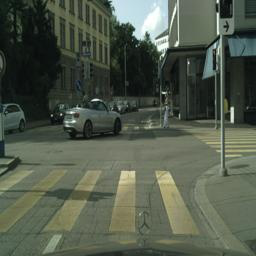

In [26]:
img = Image.open(images[10]).convert("RGB")
img.crop((0,0,img.size[0]/2, img.size[1]))


# Dataloader for Siamese Network
* For Every Index call There is a 50% Chances that 2 Similar Differntly Distorted Images are send to Model with Target = 0 Representing Similar Images or other 50% Chances that 2 totally Images are send with target set to 1

In [47]:
class CityDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        self.len_dataset = len(dataset)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self , idx):
        img = Image.open(self.dataset[idx]).convert('RGB')
        img = img.crop((0,0,img.size[0]/2 , img.size[1]))
        img1 = self.transform(img)

        if uniform(0,1) > 0.5:
            img2 = Image.open(self.dataset[np.random.choice(self.len_dataset, 1)[0]]).convert('RGB')
            img2 = img2.crop((0,0,img2.size[0]/2 , img2.size[1]))
            img2 = self.transform(img2)
            target = 0
        else:
            img2 = self.transform(img)
            target = 1
        
        return img1, img2 , torch.tensor(target)
        
transforms = T.Compose([
    T.Resize((224,224)),
    T.RandomVerticalFlip(0.4),
    T.RandomRotation((-.5,.5)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.RandomErasing()
])

dataset_t = CityDataset(images , transforms)     
dataset_v = CityDataset(vimages , transforms)     

In [ ]:
BATCH_SIZE = 64
NUM_WORKER = 2
train_loader = DataLoader(
    dataset=dataset_t,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=dataset_v,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True
)

In [7]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=3):
        super(Encoder, self).__init__()
        
        self.enc_image_size = encoded_image_size
        net = torchvision.models.resnet50(pretrained=True) # Using Resnet Pretrained Model
        modules = list(net.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.out_dim = 2048

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(encoded_image_size*encoded_image_size*2048 , 512) # Set to Final Embedding Size (Default to 512)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune() # Setting Training True for Last 2 Layers of models
        
    def get_out_dim(self):
        return self.out_dim

    def forward_once(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1) # Bringing out_dim to dimension to 3
        out = out.view(out.size(0), -1, out.size(-1))
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def forward(self , image1, image2):
        image1 = self.forward_once(image1)
        image2 = self.forward_once(image2)
        return image1, image2
    
    def fine_tune(self, last_x = 1,fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[-last_x]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [38]:
class Pytorch_Trainer():
    """
    Custom Pytorch Trainer Model Which makes easy to Train Pytorch Model
    BY: KAUSTUBH PATHAK
    """
    def __init__(self):
        super().__init__()
        self._BT_Avg_Loss_Train = []
        self._BT_Avg_Loss_Valid = []
        self._Loss_df = []
        self.max_grad_norm = 1
        self.__Use_CLR = False
        self.model_save_path = '/content/drive/MyDrive/LambdaTest/models'
        os.makedirs(self.model_save_path, exist_ok=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # To Save Model after Training (Trainer dont have Automatic Saving to Save Best Model while Training { To Implement})
    def _Save_Model(self , model , optimizer ,  path):
        checkpoint = {
            'Training Loss': self._BT_Avg_Loss_Train,
            'Validation Loss': self._BT_Avg_Loss_Valid,
            'Loss df': self._Loss_df,
            'Optimizer': optimizer.state_dict(),
            'State_Dict': model.state_dict()
                     }
        torch.save(checkpoint , path)
        print('Model Saved Successfully....')

    # Load the Saved Model and Optimizer
    def _Load_Model(self, model, optimizer ,path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['State_Dict'])
        self._BT_Avg_Loss_Train = checkpoint['Training Loss']
        self._BT_Avg_Loss_Valid = checkpoint['Validation Loss']
        self._Loss_df = checkpoint['Loss df']
        optimizer.load_state_dict(checkpoint['Optimizer'])
        print('Loading Completed....')
        return model, optimizer

    # Switch Between Training and Evaluation modes.
    def _Train_Eval(self , model , mode):
        if mode.lower() == 'train':
            model.train()
            torch.set_grad_enabled(True)
        elif mode.lower() == 'eval':
            model.eval()
            torch.set_grad_enabled(False)
        else:
            raise Exception("Unknown Type....!! Set to 'Train' or 'Eval'")

    # Predict Function (Correctly {Not for Large Datasets.})
    def _Predict(self , model, x):
        model._Train_Eval(mode = 'Eval')
        x = torch.tensor(x).to(device)
        return  model(x).detach()

    # Run/Train the Model with Automatic Mixed Precision
    def fit(self , model , optimizer , loss , dataloader , validloader ,scheduler = None,ex_flag = 0, epochs = 'Default' , use_grad = False):
        print('Abbreviations : \n\tV.S. -> Validation Size \tV.L. -> Validation Loss \tT.S. -> Training Size \tT.L. -> Training Loss \tT.T. -> Training Time\nResults : ')
        loss = loss.to(self.device)
        model = model.to(self.device)
        if epochs == 'Default':
            epochs = 10
        if use_grad:
            scaler = GradScaler()

        for j in range(epochs):
            time_now = time.time()
            self._Train_Eval(model, mode = 'Train')
            Train_Total_Loss = 0 #For Epoch Loss
            for x_train , y_train , target in dataloader:
                x_train , y_train , target = x_train.to(device) , y_train.to(device) , target.to(device)

                optimizer.zero_grad()
                if use_grad:
                    with autocast():
                        embed_x, embed_y = model.__call__(x_train , y_train)
                        loss_value = loss(embed_x, embed_y, (2*target)-1) # for CosineEmbeddingLoss
                    scale_before_step = scaler.get_scale()
                    scaler.scale(loss_value).backward()
                    scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
                    scaler.step(self.optimizer)
                    scaler.update()
                    skip_scheduler = scaler.get_scale() != scale_before_step
                else:
                    embed_x, embed_y  = model.__call__(x_train , y_train )
                    loss_value =  loss(embed_x, embed_y, (2*target)-1)

                    loss_value.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
                    optimizer.step()
                if scheduler != None:
                    scheduler.step() # Stepping If using Cyclic Learning Rate ()
                if ex_flag % 20 == 0:
                    self._Save_Model(model , optimizer , f'{self.model_save_path}/epochs{j+1}_ex_flag_{ex_flag} .pt')
                    print(f'Iteration : {ex_flag} Batch Loss : {round(loss_value.item() , 5)}')
                self._BT_Avg_Loss_Train.append([j,ex_flag,loss_value.item()]) # Otherwise Simple Append

                Train_Total_Loss += loss_value.item() #For Epoch Loss
                ex_flag += 1 #Flag

            #### For Evaluation ....
            self._Train_Eval(model , mode = 'Eval') # Switching to Evaluation Mode
            ex_flag = 0 #Flag
            Valid_Total_Loss = 0 # For Calculating Validation Loss

            for x_train , y_train ,  target in validloader:
                x_train , y_train , target = x_train.to(device) , y_train.to(device) , target.to(device)

                if use_grad:
                    with autocast():
                        embed_x, embed_y = model.__call__(x_train , y_train)
                        loss_value = loss(embed_x, embed_y, (2*target)-1)
                else:
                    embed_x, embed_y  = model.__call__(x_train , y_train) # Calling to get Prediction
                    loss_value = loss(embed_x, embed_y, (2*target)-1)  # Calculating the Loss
                self._BT_Avg_Loss_Valid.append([j,ex_flag , loss_value.item()]) # Otherwise Simple Append
                Valid_Total_Loss += loss_value.item() #Epoch Validation Loss
                ex_flag += 1 #Flag
            
            print('Epoch : {} | V.S. : {} | V.L. : {:07.5f} | T.S. : {} | T.L : {:07.5f} | T.T. : {:05.3f} Sec ||'.\
                        format(\
                                j+1 , \
                                len(validloader),round(Valid_Total_Loss / len(validloader) , 5) ,
                                len(dataloader) , round(Train_Total_Loss / len(dataloader) , 5) ,
                                round(time.time() - time_now,3)
                                )\
                        )

            self._Loss_df.append(
                            {
                            'Epoch':j ,
                            'Training Loss': Train_Total_Loss/len(dataloader) ,
                            'Validation Loss':  Valid_Total_Loss / len(validloader)
                            }
                        )


In [39]:
model = Encoder()
trainer = Pytorch_Trainer()

loss = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0*0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
trainer.fit(model , optimizer, loss, train_loader , valid_loader)

Abbreviations : 
	V.S. -> Validation Size 	V.L. -> Validation Loss 	T.S. -> Training Size 	T.L. -> Training Loss 	T.T. -> Training Time
Results : 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Model Saved Successfully....
Iteration : 0 Batch Loss : 0.41876
Model Saved Successfully....
Iteration : 20 Batch Loss : 0.42413
Model Saved Successfully....
Iteration : 40 Batch Loss : 0.36684
Epoch : 1 | V.S. : 8 | V.L. : 0.33417 | T.S. : 47 | T.L : 0.39140 | T.T. : 45.989 Sec ||
Model Saved Successfully....
Iteration : 20 Batch Loss : 0.23795
Model Saved Successfully....
Iteration : 40 Batch Loss : 0.19081
Epoch : 2 | V.S. : 8 | V.L. : 0.20595 | T.S. : 47 | T.L : 0.24405 | T.T. : 42.957 Sec ||
Model Saved Successfully....
Iteration : 20 Batch Loss : 0.1701
Model Saved Successfully....
Iteration : 40 Batch Loss : 0.18075
Epoch : 3 | V.S. : 8 | V.L. : 0.17936 | T.S. : 47 | T.L : 0.18351 | T.T. : 42.954 Sec ||
Model Saved Successfully....
Iteration : 20 Batch Loss : 0.10078
Model Saved Successfully....
Iteration : 40 Batch Loss : 0.16028
Epoch : 4 | V.S. : 8 | V.L. : 0.19707 | T.S. : 47 | T.L : 0.16753 | T.T. : 42.263 Sec ||
Model Saved Successfully....
Iteration : 20 Batch Loss : 0.09

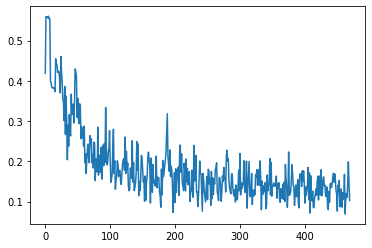

In [44]:
# Plotting Training Loss over 5 epochs
pd.DataFrame(trainer._BT_Avg_Loss_Train)[2].plot()

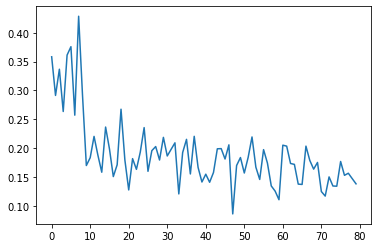

In [43]:
# Plotting Validation Loss over 5 epochs
pd.DataFrame(trainer._BT_Avg_Loss_Valid)[2].plot()

### Since There is Evaluation Matrix to test Dimensionality Reduction, I Checked for Dimesions of 2 similar images and 2 Differnt Images

In [28]:
def get_dimens(model , trans , path = '/content/drive/MyDrive/Colab Notebooks/database/cityscapes_data/train/1028.jpg'):
    img = Image.open(path).convert('RGB')
    img = trans(img).to(device)
    model.eval()
    embed = model.forward_once(img.unsqueeze(0))
    return embed


In [37]:
final_T = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

cosine_similarity(get_dimens(model , final_T , '/content/drive/MyDrive/Colab Notebooks/database/cityscapes_data/val/51.jpg').detach().cpu().numpy() , \
                  get_dimens(model , transforms , '/content/drive/MyDrive/Colab Notebooks/database/cityscapes_data/val/51.jpg').detach().cpu().numpy())

array([[0.99999994]], dtype=float32)